In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
from snsynth import MWEMSynthesizer
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN

from diffprivlib.models import LogisticRegression as DPLR

# 4. Adult dataset

## 4.1 Non-private data processing

In [3]:
# Read in the original data
adult_cols = ['age','workclass', 'fnlwgt', 'education', 'education_num', 'marital', 
              'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
              'hours_week', 'native_country', 'label']
adult_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
adult_data = pd.read_csv(adult_path, skipinitialspace=True, names=adult_cols, index_col=False)
adult_data.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
workclass = {
    0:"Private",
    -1:"Self-emp-not-inc",
    1:"Local-gov",
    -2:"State-gov",
    2:"Self-emp-inc",
    -3:"Federal-gov",
    3:"Without-pay",
    -4:"Never-worked"
}

education = {
    0:"HS-grad",
    -1:"Some-college",
    1:"Bachelors",
    -2:"Masters",
    2:"Assoc-voc",
    -3:"11th",
    3:"Assoc-acdm",
    -4:"10th",
    4:"7th-8th",
    -5:"Prof-school",
    5:"9th",
    -6:"12th",
    6:"Doctorate",
    -7:"5th-6th",
    7:"1st-4th",
    -8:"Preschool"
}

occupation = {
    0:"Prof-specialty",
    -1:"Craft-repair",
    1:"Exec-managerial",
    -2:"Adm-clerical",
    2:"Sales",
    -3:"Other-service",
    3:"Machine-op-inspct",
    -4:"Transport-moving",
    4:"Handlers-cleaners",
    -5:"Farming-fishing",
    5:"Tech-support",
    -6:"Protective-serv",
    6:"Priv-house-serv",
    -7:"Armed-Forces"
}

relationship = {
    0:"Husband",
    -1:"Not-in-family",
    1:"Own-child",
    -2:"Unmarried",
    2:"Wife",
    -3:"Other-relative"
}

race = {
    0:"White",
    -1:"Black",
    1:"Asian-Pac-Islander",
    -2:"Amer-Indian-Eskimo",
    2:"Other"
}

In [5]:
def process_adult(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["fnlwgt", "native_country", "capital_gain", "capital_loss", "marital"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    #numerical_features = ["age", "education_num", "hours_week"]
    #scaler = MinMaxScaler()
    #df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode the categorical features
    categorical_features = ["workclass", "education", "occupation", "relationship", "race"]
    df["workclass"] = df["workclass"].map({v: k for k, v in workclass.items()})
    df["education"] = df["education"].map({v: k for k, v in education.items()})
    df["occupation"] = df["occupation"].map({v: k for k, v in occupation.items()})
    df["relationship"] = df["relationship"].map({v: k for k, v in relationship.items()})
    df["race"] = df["race"].map({v: k for k, v in race.items()})
    
    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    df["over_under_50k"] = df["label"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    return df

In [6]:
# Get the processed adult data
processed_adult = process_adult(adult_data)
processed_adult

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label,gender_labs,over_under_50k
0,39,-2,1,13,-2,-1,0,1,40,0,Male,<=50K
1,50,-1,1,13,1,0,0,1,13,0,Male,<=50K
2,38,0,0,9,4,-1,0,1,40,0,Male,<=50K
3,53,0,-3,7,4,0,-1,1,40,0,Male,<=50K
4,28,0,1,13,0,2,-1,0,40,0,Female,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0,3,12,5,2,0,0,38,0,Female,<=50K
32557,40,0,0,9,3,0,0,1,40,1,Male,>50K
32558,58,0,0,9,-2,-2,0,0,40,0,Female,<=50K
32559,22,0,0,9,-2,1,0,1,20,0,Male,<=50K


In [7]:
# Split processed data into train and test
X, y = processed_adult.drop(["label", "gender_labs", "over_under_50k"], axis=1), processed_adult["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [40]:
def adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test", method="logistic"):
    '''
    Binary classification pipeline for the
    Adult dataset.

    INPUTS
    ======
    X_train: input training data, pandas DataFrame
    y_train: output training labels, 1-d array-like
    X_test: input test data, pandas DataFrame
    y_test: output test labels, 1-d array-like
    evaluate: whether to evaluate on the train or
    test set, default='test', str
    method: binary classification method, 
    default='logistic', str

    RETURNS
    =======
    Two tuples containing the number of true positive 
    predictions (TP), false positive predictions (FP), 
    true negative predictions (TN), and false negative (FN)
    predictions on the test set for female and male, 
    respectively.
    '''

    if method == "logistic":

        # Train logistic regression classifier
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        # Predit on train and test
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    elif evaluate == "train":
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    else:
        raise Exception("evaluate must be either 'train' or 'test'")

    # Count the number of true positive and true negative preds for men and women
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])

    # Count the number of true negative and false negative preds for men and women
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])

    return (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)

In [9]:
def adult_fairness_summary(female_tup, male_tup, show_plots=False, evaluate="test"):
    '''
    Function to process and provide a summary 
    of fairness metrics for the Adult data set.

    INPUTS
    ======
    female_tup: tuple or list containing TP, FP, 
    TN, FN for female
    male_tup: tuple or list containing TP, FP, 
    TN, FN for male
    show_plots: whether to display graphs showing 
    fairness metrics for male and female, default=False, 
    bool

    RETURNS
    =======
    True positive rate for (TPR) and false positive
    rate (FPR) for female and male, respectively.
    '''

    # Unpack tuples
    TP_f, FP_f, TN_f, FN_f = female_tup
    TP_m, FP_m, TN_m, FN_m = male_tup

    # Calculate TPR, FPR for female and male
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)

    # Create summary plots
    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs = axs.ravel()
        axs[0].bar(["female", "male"], [TPR_f, TPR_m], color=["orange", "dodgerblue"])
        axs[0].set_ylabel("TPR")
        axs[1].bar(["female", "male"], [FPR_f, FPR_m], color=["orange", "dodgerblue"])
        axs[1].set_ylabel("FPR")
        fig.suptitle(f"TPR and FPR for female vs male ({evaluate} data)", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])

    return TPR_f, TPR_m, FPR_f, FPR_m

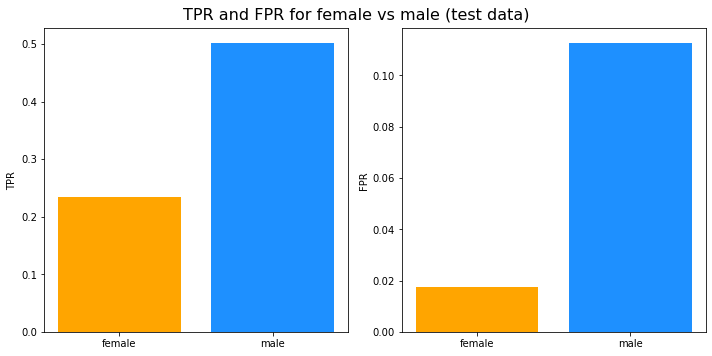

In [10]:
# Run the binary classification pipeline on the original processed data and evaluation on training data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test")

# Calculate and visualize TPR and FPR on the training data for female and male
TPR_f_non_priv, TPR_m_non_priv, FPR_f_non_priv, FPR_m_non_priv = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="test")

In [11]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff_non_priv = TPR_m_non_priv-TPR_f_non_priv

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff_non_priv = FPR_m_non_priv-FPR_f_non_priv

# Demographic parity (FP + TP rate difference)
dem_parity_non_priv = (FPR_m_non_priv+TPR_m_non_priv)-(FPR_f_non_priv+TPR_f_non_priv)

# Calculate overall accuracy for female and male
ACC_f_non_priv = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m_non_priv = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TRAINING DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff_non_priv:.4f}")
print(f"The difference in FPR (equalized odds) is: {FPR_diff_non_priv:.4f}")
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity_non_priv:.4f}")
print(f"The overall accuracy for female is: {ACC_f_non_priv:.4f}")
print(f"The overall accuracy for male is: {ACC_m_non_priv:.4f}")

TRAINING DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.2681
The difference in FPR (equalized odds) is: 0.0954
The difference in FP + TP rate (Demographic Parity) is: 0.3635
The overall accuracy for female is: 0.8971
The overall accuracy for male is: 0.7640


## 4.2 MWEM

### 4.2.1 Data preparation

Based on multiplicative weight update mechanism; requires binning of continuous data.

In [12]:
# Recombine X_train and y_train for synthesis
adult_train = pd.concat([X_train, y_train], axis=1)
adult_train

,age,workclass,education,education_num,occupation,relationship,race,sex,hours_week,label
15213,24,0,1,13,-2,2,0,0,50,0
5841,50,0,-2,14,0,-3,0,1,60,0
26610,41,1,-1,10,-2,2,-1,0,40,0
30332,39,0,0,9,3,-1,-1,1,40,0
26117,46,0,0,9,-3,0,0,1,50,0
...,...,...,...,...,...,...,...,...,...,...
13918,55,0,1,13,3,-2,0,0,40,0
20822,50,2,-1,10,1,-2,0,0,75,0
10456,27,0,2,11,3,-1,0,1,40,0
11475,28,1,-1,10,1,0,0,1,65,0


In [13]:
# Recombine X_test and y_test for synthesis
adult_test = pd.concat([X_test, y_test], axis=1)

### 4.2.2 Varying $\varepsilon$

In [14]:
def get_synthesizer(synthesizer, epsilon):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
        splits=[], split_factor=2, max_bin_count=400)

    elif synthesizer == "DPCTGAN":
        synth = PytorchDPSynthesizer(epsilon=epsilon, gan=DPCTGAN(), preprocessor=None)

    return synth

In [32]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate a synthesizer
    if synthesizer == "MWEM":
        def QuailSynth(epsilon):
            return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
        
    elif synthesizer == "DPCTGAN":
        def QuailSynth(epsilon):
            return PytorchDPSynthesizer(epsilon=epsilon, gan=DPCTGAN(), preprocessor=None)
    
    # Instantiate a DPLR classifier
    if classifier == "DPLR":
        def QuailClassifier(epsilon):
            return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split)

    return quail

In [41]:
def adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                    quail=False, classifier=None, eps_split=None, n_reps=1):
    '''
    Calculates fairness metrics for binary
    classification on Adult data obtained by
    training classifier on synthetic training
    data and testing on non-private test data.
    
    INPUTS
    ======
    epsilon_vals: list containing privacy loss
    parameter values to apply, array-like
    adult_train: non-private training data (X and 
    y) to train synthesizer, pandas DataFrame
    adult_test: non-private test data (X and y)
    synthesizer: the type of synthesizer to use, str
    n_reps: the number of synthetic data sets to
    generate for each epsilon, int
    
    RETURNS
    =======
    Dictionary where each key is an epsilon and 
    each value is a list of four lists containing
    the TPR_f, TPR_m, FPR_f, FPR_m values obtained
    (e.g. each list will have two values if n_reps=2)
    '''
    
    # Initialize dictionary of fairness metrics
    fairness_dict = {}
    
    for epsilon in epsilon_vals:
        
        for i in range(n_reps):

            if quail:  
                # Create a QUAIL-wrapped synthesizer
                synth = get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target="label")

                # Fit synthesizer to the training data
                synth.fit(adult_train)

            else:
                # Create a regular synthesizer
                synth = get_synthesizer(synthesizer, epsilon)

                if synthesizer == "MWEM":
        
                    # Fit synthesizer to the training data
                    synth.fit(adult_train.to_numpy())

                elif synthesizer == "DPCTGAN":

                  # Fit synthesizer to the training data
                  synth.fit(adult_train, categorical_columns=["workclass", "education", "occupation", "relationship", "race", "sex", "label"])

            # Create private synthetic data
            adult_train_synth = pd.DataFrame(synth.sample(int(adult_train.shape[0])), columns=adult_train.columns)
            
            # Split synthetic training data into X and y
            X_train, y_train = adult_train_synth.drop(["label"], axis=1), adult_train_synth["label"]
            
            # Split the non-private test data into X and y
            X_test, y_test = adult_test.drop(["label"], axis=1), adult_test["label"]
            
            # Check if all synthetic labels are 0 or 1
            synth_label_mean = np.mean(y_train)
            if synth_label_mean == 0.0 or synth_label_mean == 1.0:
                print(f"Warning! All synthetic data labels are {synth_label_mean}. Skipping trial.")
            
            # Run the binary classification pipeline
            else:
                female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test)

                # Add female and male tuples to dictionary
                if epsilon not in fairness_dict.keys():
                    fairness_dict[epsilon] = [[female_tup], [male_tup]]
                else:
                    fairness_dict[epsilon][0].append(female_tup)
                    fairness_dict[epsilon][1].append(male_tup)
                
            print(f"Completed eps={epsilon}, rep={i+1}.")
        
    return fairness_dict

In [17]:
try:
    # Try to load the dictionary with one repetition
    adult_fairness_mwem_1 = np.load("adult_fairness_mwem_1.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of fairness metrics with 1 repetition for range of values
    adult_fairness_mwem_1 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=1)
    
    # Save dictionary
    np.save("adult_fairness_mwem_1.npy", adult_fairness_mwem_1)

In [18]:
def get_fairness_arrays(fairness_dict):
    
    # Initialize lists to hold epsilon and fairness metrics
    epsilon_vals = []
    tpr_f_arr = []
    tpr_m_arr = []
    fpr_f_arr = []
    fpr_m_arr = []
    tpr_diff_arr = []
    fpr_diff_arr = []
    acc_f_arr = []
    acc_m_arr = []

    # Loop through the dictionary of results
    for epsilon, metric_list in fairness_dict.items():

        # Get the metrics for female and male
        female_arr, male_arr = metric_list
        n_reps = len(female_arr)
        epsilon_vals.append(epsilon)

        # Initialize more lists
        if n_reps > 1:
            tpr_f_vals = []
            tpr_m_vals = []
            fpr_f_vals = []
            fpr_m_vals = []
            tpr_diff_vals = []
            fpr_diff_vals = []
            acc_f_vals = []
            acc_m_vals = []
        
        # Loop through the tuples
        for female_tup, male_tup in zip(female_arr, male_arr):
        
            # Get the fairness metrics
            TPR_f, TPR_m, FPR_f, FPR_m = adult_fairness_summary(female_tup, male_tup)

            # Calculate the equalized odds distances
            tpr_diff = TPR_m-TPR_f
            fpr_diff = FPR_m-FPR_f
            
            # Calculate the accuracies
            acc_f = (female_tup[0] + female_tup[2]) / sum(female_tup)
            acc_m = (male_tup[0] + male_tup[2]) / sum(male_tup)
            
            # Append metrics to arrays
            if n_reps > 1:
                tpr_f_vals.append(TPR_f)
                tpr_m_vals.append(TPR_m)
                fpr_f_vals.append(FPR_f)
                fpr_m_vals.append(FPR_m)
                tpr_diff_vals.append(tpr_diff)
                fpr_diff_vals.append(fpr_diff)
                acc_f_vals.append(acc_f)
                acc_m_vals.append(acc_m)
            else:
                tpr_f_arr.append(TPR_f)
                tpr_m_arr.append(TPR_m)
                fpr_f_arr.append(FPR_f)
                fpr_m_arr.append(FPR_m)
                tpr_diff_arr.append(tpr_diff)
                fpr_diff_arr.append(fpr_diff)
                acc_f_arr.append(acc_f)
                acc_m_arr.append(acc_m)
            
        # Add lists to arrays
        if n_reps > 1:
            tpr_f_arr.append(tpr_f_vals)
            tpr_m_arr.append(tpr_m_vals)
            fpr_f_arr.append(fpr_f_vals)
            fpr_m_arr.append(fpr_m_vals)
            tpr_diff_arr.append(tpr_diff_vals)
            fpr_diff_arr.append(fpr_diff_vals)
            acc_f_arr.append(acc_f_vals)
            acc_m_arr.append(acc_m_vals)
        
    return epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr

In [19]:
def plot_fairness_dict(fairness_dict, plot_non_private=False):

    # Get fairness arrays for plotting
    epsilon_vals, tpr_f_arr, tpr_m_arr, fpr_f_arr, fpr_m_arr, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(fairness_dict)    

    # Line plot if there was only one repetition
    if isinstance(tpr_f_arr[0], float):
        
        # Initialize a figure
        fig, axs = plt.subplots(2, 2, figsize=(15,12))
        axs = axs.ravel()
        
        if plot_non_private:
            min_eps = np.min(epsilon_vals)
            max_eps = np.max(epsilon_vals)
            axs[0].hlines(TPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female TPR")
            axs[0].hlines(TPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male TPR")            
            axs[1].hlines(FPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female FPR")
            axs[1].hlines(FPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male FPR")    
            axs[2].hlines(TPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private TPR dist")
            axs[2].hlines(FPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private FPR dist")
            axs[3].hlines(ACC_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
            axs[3].hlines(ACC_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
        axs[0].plot(epsilon_vals, tpr_f_arr, label="Female TPR", c="darkorange", marker='o')
        axs[0].plot(epsilon_vals, tpr_m_arr, label="Male TPR", c="royalblue", marker='o')
        axs[0].set_ylabel("True positive rate")
        axs[0].set_title("True positive rates for female vs male", fontsize=18)
        axs[1].plot(epsilon_vals, fpr_f_arr, label="Female FPR", c="darkorange", marker='o')
        axs[1].plot(epsilon_vals, fpr_m_arr, label="Male FPR", c="royalblue", marker='o')
        axs[1].set_ylabel("False positive rate")
        axs[1].set_title("False positive rates for female vs male", fontsize=18)
        axs[2].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
        axs[2].plot(epsilon_vals, tpr_diff_arr, label="TPR dist", c="darkorange", marker='o')
        axs[2].plot(epsilon_vals, fpr_diff_arr, label="FPR dist", c="royalblue", marker='o')
        axs[2].set_ylabel("Equalized odds distance")
        axs[2].set_title("Equalized odds distances for female vs male", fontsize=18)
        axs[3].plot(epsilon_vals, acc_f_arr, label="Female", c="darkorange", marker='o')
        axs[3].plot(epsilon_vals, acc_m_arr, label="Male", c="royalblue", marker='o')
        axs[3].set_ylabel("Overall accuracy")
        axs[3].set_title("Classification accuracies for female vs male", fontsize=18)
        fig.suptitle("Adult dataset fairness metrics (1 repetition)", fontsize=22)
        for i in range(4):
            axs[i].set_xlabel("Privacy loss (epsilon)")
            axs[i].xaxis.get_label().set_fontsize(18)
            axs[i].yaxis.get_label().set_fontsize(18)
            axs[i].legend()
    else:
        
        # Initialize a figure
        fig, axs = plt.subplots(4, 2, figsize=(15,20))
        axs = axs.ravel()
        
        # Prepare for plotting
        n_reps = len(tpr_f_arr[0])
        medianprops_f = dict(color='darkorange')
        medianprops_m = dict(color='royalblue')
        
        if plot_non_private:
            min_eps = 0.5
            max_eps = len(epsilon_vals)+0.5
            axs[0].hlines(TPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female TPR")
            axs[1].hlines(TPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male TPR")            
            axs[2].hlines(FPR_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private female FPR")
            axs[3].hlines(FPR_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private male FPR")    
            axs[4].hlines(TPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="red", linestyles="--", label="Non-private TPR dist")
            axs[5].hlines(FPR_diff_non_priv, xmin=min_eps, xmax=max_eps, colors="red", linestyles="--", label="Non-private FPR dist")
            axs[6].hlines(ACC_f_non_priv, xmin=min_eps, xmax=max_eps, colors="darkorange", linestyles="--", label="Non-private Female")
            axs[7].hlines(ACC_m_non_priv, xmin=min_eps, xmax=max_eps, colors="royalblue", linestyles="--", label="Non-private Male")
        axs[0].boxplot(tpr_f_arr, medianprops=medianprops_f)
        axs[0].set_ylabel("True positive rate")
        axs[0].set_title("True positive rates for female", fontsize=18)
        axs[1].boxplot(tpr_m_arr, medianprops=medianprops_m)
        axs[1].set_ylabel("True positive rate")
        axs[1].set_title("True positive rates for male", fontsize=18)  
        axs[2].boxplot(fpr_f_arr, medianprops=medianprops_f)
        axs[2].set_ylabel("False positive rate")
        axs[2].set_title("False positive rates for female", fontsize=18)        
        axs[3].boxplot(fpr_m_arr, medianprops=medianprops_m)
        axs[3].set_ylabel("False positive rate")
        axs[3].set_title("False positive rates for male", fontsize=18)
        axs[4].boxplot(tpr_diff_arr, medianprops=dict(color="red"))
        axs[4].set_ylabel("Equalized odds distance")
        axs[4].set_title("Equalized odds distances (y=1)", fontsize=18)
        axs[4].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")       
        axs[5].boxplot(fpr_diff_arr, medianprops=dict(color="red"))
        axs[5].set_ylabel("Equalized odds distance")
        axs[5].set_title("Equalized odds distances (y=0)", fontsize=18)
        axs[5].hlines(0, xmin=min_eps, xmax=max_eps, colors="grey", linestyles="--", label="Perfect fairness")
        axs[6].boxplot(acc_f_arr, medianprops=medianprops_f)
        axs[6].set_ylabel("Overall accuracy")
        axs[6].set_title("Classification accuracies for female", fontsize=18)  
        axs[7].boxplot(acc_m_arr, medianprops=medianprops_m)
        axs[7].set_ylabel("Overall accuracy")
        axs[7].set_title("Classification accuracies for male", fontsize=18)
        fig.suptitle(f"Adult dataset fairness metrics ({n_reps} repetitions)", fontsize=22)
        for i in range(8):
            axs[i].set_xticklabels(epsilon_vals)
            axs[i].set_xlabel("Privacy loss (epsilon)")
            axs[i].xaxis.get_label().set_fontsize(18)
            axs[i].yaxis.get_label().set_fontsize(18)
            axs[i].legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

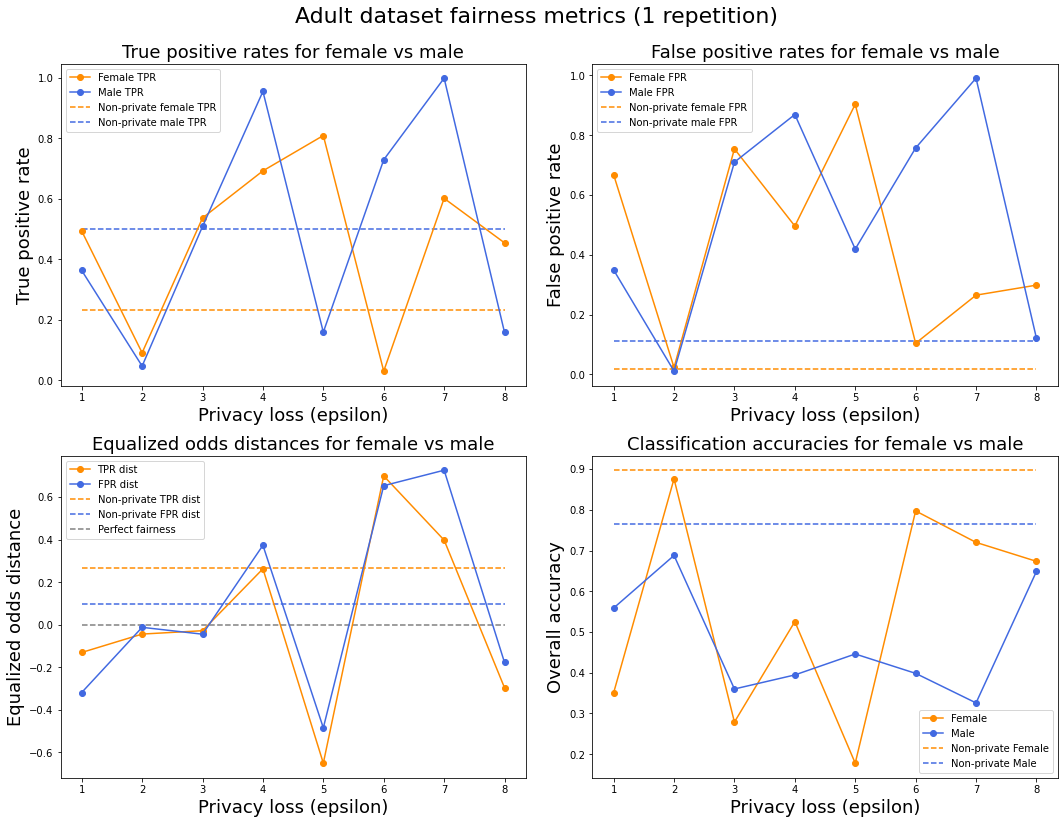

In [20]:
# Plot the fairness and accuracy metrics for 1 repetition
plot_fairness_dict(adult_fairness_mwem_1, plot_non_private=True)

In [21]:
try:
    # Try to load the dictionary with ten repetitions
    adult_fairness_mwem_2 = np.load("adult_fairness_mwem_2.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    adult_fairness_mwem_2 = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=15)
    
    # Save dictionary
    np.save("adult_fairness_mwem_2.npy", adult_fairness_mwem_2)

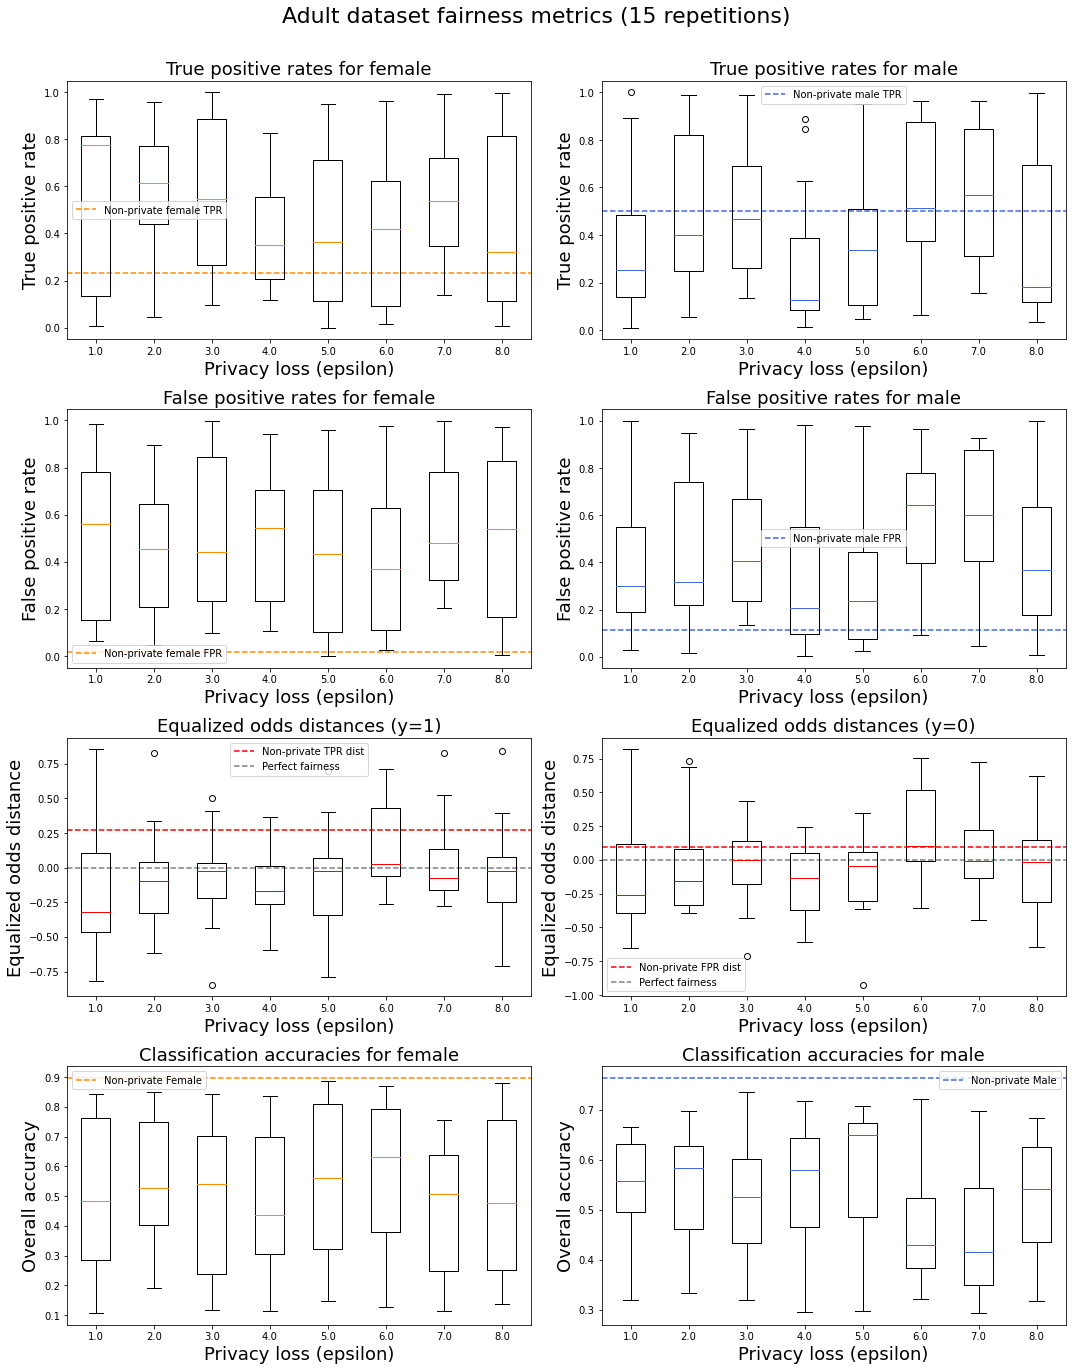

In [22]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_mwem_2, plot_non_private=True)

In [23]:
# Get the overall average fairness and accuracy metrics
_, _, _, _, _, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(adult_fairness_mwem_2)
print(f"The overall median TPR difference is {np.median(sum(tpr_diff_arr, [])):.4f}")
print(f"The overall median FPR difference is {np.median(sum(fpr_diff_arr, [])):.4f}")
print(f"The overall median accuracy for female is {np.median(sum(acc_f_arr, [])):.4f}")
print(f"The overall median accuracy for male is {np.median(sum(acc_m_arr, [])):.4f}")

The overall median TPR difference is -0.0409
The overall median FPR difference is -0.0182
The overall median accuracy for female is 0.5294
The overall median accuracy for male is 0.5352


## 4.3 QUAIL-MWEM

In [24]:
try:
    # Try to load the dictionary with ten repetitions
    adult_fairness_quail_mwem = np.load("adult_fairness_quail_mwem.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    adult_fairness_quail_mwem = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("adult_fairness_quail_mwem.npy", adult_fairness_quail_mwem)

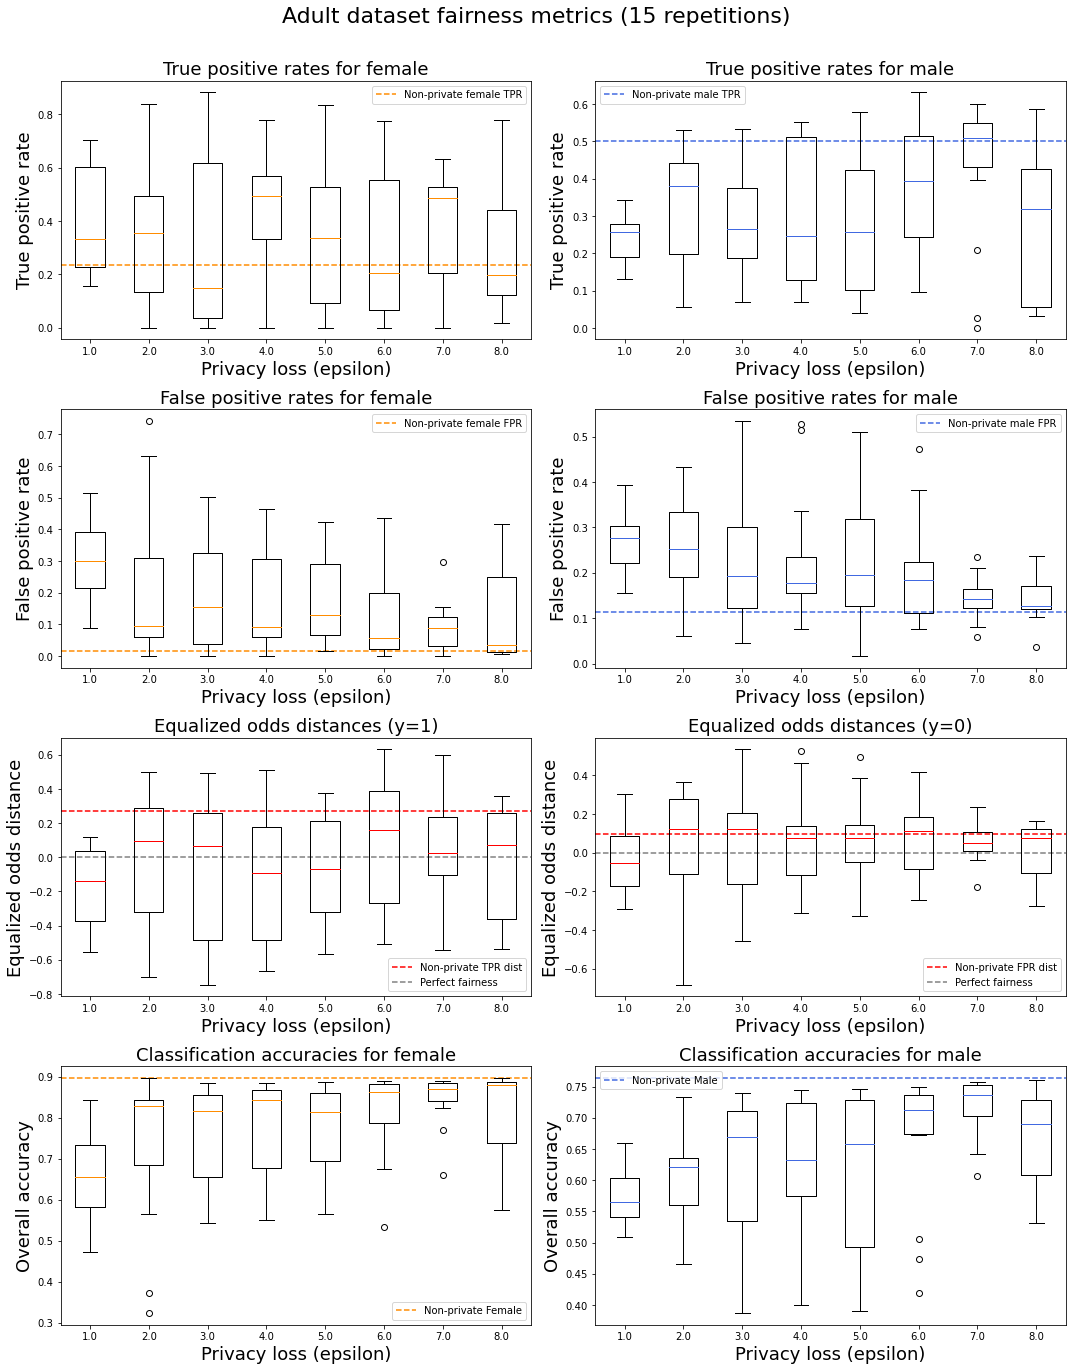

In [25]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_quail_mwem, plot_non_private=True)

In [26]:
# Get the overall average fairness and accuracy metrics
_, _, _, _, _, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(adult_fairness_quail_mwem)
print(f"The overall median TPR difference is {np.median(sum(tpr_diff_arr, [])):.4f}")
print(f"The overall median FPR difference is {np.median(sum(fpr_diff_arr, [])):.4f}")
print(f"The overall median accuracy for female is {np.median(sum(acc_f_arr, [])):.4f}")
print(f"The overall median accuracy for male is {np.median(sum(acc_m_arr, [])):.4f}")

The overall median TPR difference is 0.0112
The overall median FPR difference is 0.0695
The overall median accuracy for female is 0.8273
The overall median accuracy for male is 0.6551


## 4.4 DP-CTGAN

In [27]:
# Load the separate DPCTGAN files
adult_fairness_dpctgan_12 = np.load("adult_fairness_dpctgan_12.npy", allow_pickle=True).item()
adult_fairness_dpctgan_3 = np.load("adult_fairness_dpctgan_3.npy", allow_pickle=True).item()
adult_fairness_dpctgan_4 = np.load("adult_fairness_dpctgan_4.npy", allow_pickle=True).item()
adult_fairness_dpctgan_5 = np.load("adult_fairness_dpctgan_5.npy", allow_pickle=True).item()
adult_fairness_dpctgan_6 = np.load("adult_fairness_dpctgan_6.npy", allow_pickle=True).item()
adult_fairness_dpctgan_7 = np.load("adult_fairness_dpctgan_7.npy", allow_pickle=True).item()
adult_fairness_dpctgan_8 = np.load("adult_fairness_dpctgan_8.npy", allow_pickle=True).item()

# Join the separate files
adult_fairness_dpctgan = {**adult_fairness_dpctgan_12, **adult_fairness_dpctgan_3, 
                          **adult_fairness_dpctgan_4, **adult_fairness_dpctgan_5, 
                          **adult_fairness_dpctgan_6, **adult_fairness_dpctgan_7, 
                          **adult_fairness_dpctgan_8}

In [28]:
# Save the full DPCTGAN file
np.save("adult_fairness_dpctgan.npy", adult_fairness_dpctgan)

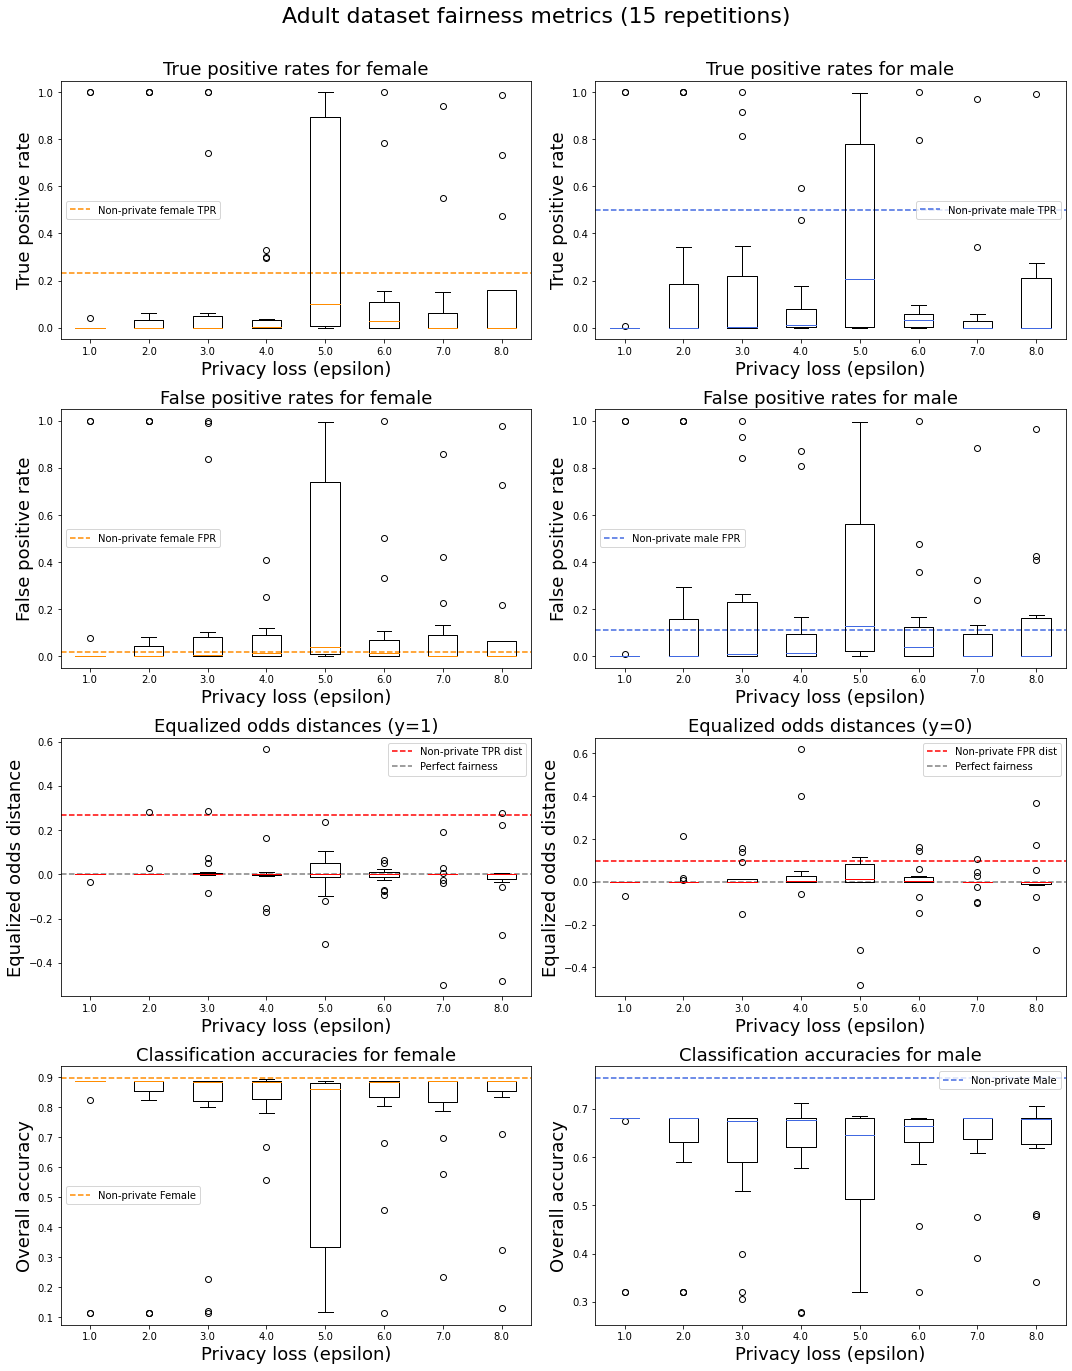

In [29]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_dpctgan, plot_non_private=True)

In [30]:
# Get the overall average fairness and accuracy metrics
_, _, _, _, _, tpr_diff_arr, fpr_diff_arr, acc_f_arr, acc_m_arr = get_fairness_arrays(adult_fairness_dpctgan)
print(f"The overall median TPR difference is {np.median(sum(tpr_diff_arr, [])):.4f}")
print(f"The overall median FPR difference is {np.median(sum(fpr_diff_arr, [])):.4f}")
print(f"The overall median accuracy for female is {np.median(sum(acc_f_arr, [])):.4f}")
print(f"The overall median accuracy for male is {np.median(sum(acc_m_arr, [])):.4f}")

The overall median TPR difference is 0.0000
The overall median FPR difference is 0.0000
The overall median accuracy for female is 0.8852
The overall median accuracy for male is 0.6791


## 4.5 QUAIL-DP-CTGAN

In [42]:
try:
    # Try to load the dictionary with ten repetitions
    adult_fairness_quail_dpctgan = np.load("adult_fairness_quail_dpctgan.npy", allow_pickle=True).item()
    
except:
    # Set range of epsilon values
    epsilon_vals = [7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    adult_fairness_quail_dpctgan = adult_fairness_privacy_range(epsilon_vals, adult_train, adult_test, synthesizer="DPCTGAN", 
                                                        quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save dictionary
    np.save("adult_fairness_quail_dpctgan_78.npy", adult_fairness_quail_dpctgan)

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6227, Loss D: 1.4330
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6293, Loss D: 1.4235
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6491, Loss D: 1.4066
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6552, Loss D: 1.3843
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6477, Loss D: 1.3892
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6286, Loss D: 1.4064
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6274, Loss D: 1.3915
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6291, Loss D: 1.4008
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6325, Loss D: 1.3907
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6099, Loss D: 1.4156
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6142, Loss D: 1.4125
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6088, Loss D: 1.4114
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.7111, Loss D: 1.4336
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6842, Loss D: 1.4192
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.7019, Loss D: 1.3977
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.7131, Loss D: 1.3908
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.7343, Loss D: 1.3689
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.7292, Loss D: 1.3773
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.7210, Loss D: 1.3725
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.7217, Loss D: 1.3844
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6960, Loss D: 1.3904
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6824, Loss D: 1.3827
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6918, Loss D: 1.3777
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6833, Loss D: 1.3967
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6301, Loss D: 1.4308
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6409, Loss D: 1.4202
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6545, Loss D: 1.3894
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6648, Loss D: 1.3808
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6424, Loss D: 1.3955
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6207, Loss D: 1.4099
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6270, Loss D: 1.4083
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6310, Loss D: 1.3938
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6228, Loss D: 1.3929
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6140, Loss D: 1.3980
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6212, Loss D: 1.4065
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6130, Loss D: 1.4036
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6358, Loss D: 1.4245
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6334, Loss D: 1.4277
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6499, Loss D: 1.4080
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6567, Loss D: 1.3846
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6381, Loss D: 1.3970
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6342, Loss D: 1.4165
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6410, Loss D: 1.3966
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6497, Loss D: 1.3811
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6400, Loss D: 1.4008
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6473, Loss D: 1.3988
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6405, Loss D: 1.3941
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6418, Loss D: 1.3922
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6337, Loss D: 1.4341
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6283, Loss D: 1.4283
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6423, Loss D: 1.4025
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6428, Loss D: 1.3909
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6300, Loss D: 1.4069
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6307, Loss D: 1.3920
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6405, Loss D: 1.3996
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6423, Loss D: 1.3765
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6528, Loss D: 1.3817
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6384, Loss D: 1.3953
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6340, Loss D: 1.4086
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6415, Loss D: 1.3964
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6216, Loss D: 1.4211
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6331, Loss D: 1.4136
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6568, Loss D: 1.3872
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6556, Loss D: 1.3873
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6173, Loss D: 1.4154
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6263, Loss D: 1.4040
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6269, Loss D: 1.3960
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6059, Loss D: 1.4278
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6143, Loss D: 1.4140
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6044, Loss D: 1.4010
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6305, Loss D: 1.3923
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6191, Loss D: 1.4109
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6285, Loss D: 1.4287
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6328, Loss D: 1.4278
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6419, Loss D: 1.4052
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6473, Loss D: 1.3825
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6350, Loss D: 1.3900
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6205, Loss D: 1.4068
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6330, Loss D: 1.3921
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6314, Loss D: 1.3917
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6268, Loss D: 1.4110
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6273, Loss D: 1.3894
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6262, Loss D: 1.4012
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6240, Loss D: 1.4049
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6208, Loss D: 1.4307
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6446, Loss D: 1.4183
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6504, Loss D: 1.3816
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6565, Loss D: 1.3852
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6376, Loss D: 1.4007
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6228, Loss D: 1.4078
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6356, Loss D: 1.4075
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6419, Loss D: 1.4000
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6357, Loss D: 1.3991
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6430, Loss D: 1.4012
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6559, Loss D: 1.3791
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6561, Loss D: 1.3817
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Public\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
C:\User

Epoch 1, Loss G: 0.6340, Loss D: 1.4214
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6297, Loss D: 1.4190
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6303, Loss D: 1.3961
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6559, Loss D: 1.3770
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6374, Loss D: 1.4041
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6284, Loss D: 1.4199
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6427, Loss D: 1.4019
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6305, Loss D: 1.3998
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6189, Loss D: 1.4072
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6140, Loss D: 1.4076
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6305, Loss D: 1.4094
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6214, Loss D: 1.3976
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6283, Loss D: 1.4301
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6395, Loss D: 1.4260
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6522, Loss D: 1.4016
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6470, Loss D: 1.3902
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6354, Loss D: 1.3904
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6265, Loss D: 1.4034
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6304, Loss D: 1.4059
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6295, Loss D: 1.3897
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6378, Loss D: 1.3883
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6498, Loss D: 1.3936
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6257, Loss D: 1.3814
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6441, Loss D: 1.3856
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6595, Loss D: 1.4233
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6551, Loss D: 1.4336
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6708, Loss D: 1.3932
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6933, Loss D: 1.3885
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6878, Loss D: 1.3871
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6664, Loss D: 1.4040
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6653, Loss D: 1.4059
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6664, Loss D: 1.3887
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6694, Loss D: 1.3751
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6744, Loss D: 1.3659
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6609, Loss D: 1.3961
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6359, Loss D: 1.4149
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6272, Loss D: 1.4353
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6331, Loss D: 1.4279
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6438, Loss D: 1.3867
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6596, Loss D: 1.4010
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6334, Loss D: 1.4216
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6380, Loss D: 1.3985
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6458, Loss D: 1.4061
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6428, Loss D: 1.3919
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6476, Loss D: 1.3921
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6484, Loss D: 1.3849
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6257, Loss D: 1.4108
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6408, Loss D: 1.3925
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6418, Loss D: 1.4260
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6216, Loss D: 1.4074
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6311, Loss D: 1.3998
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6433, Loss D: 1.3925
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6492, Loss D: 1.3937
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6260, Loss D: 1.4085
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6240, Loss D: 1.4076
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6218, Loss D: 1.4152
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6268, Loss D: 1.4045
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6314, Loss D: 1.3982
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6265, Loss D: 1.3778
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6358, Loss D: 1.3887
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6323, Loss D: 1.4269
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6415, Loss D: 1.4244
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6563, Loss D: 1.3964
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6617, Loss D: 1.3889
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6417, Loss D: 1.3906
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6457, Loss D: 1.3957
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6355, Loss D: 1.3935
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6391, Loss D: 1.3942
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6369, Loss D: 1.3968
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6205, Loss D: 1.4041
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6261, Loss D: 1.4027
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6234, Loss D: 1.4011
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6328, Loss D: 1.4259
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6351, Loss D: 1.4131
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6386, Loss D: 1.3889
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6503, Loss D: 1.3829
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6460, Loss D: 1.3823
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6279, Loss D: 1.3994
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6183, Loss D: 1.4107
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6209, Loss D: 1.3962
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6445, Loss D: 1.3938
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6422, Loss D: 1.3908
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6281, Loss D: 1.4153
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6420, Loss D: 1.3957
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6244, Loss D: 1.4319
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6274, Loss D: 1.4316
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6492, Loss D: 1.4018
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6602, Loss D: 1.3791
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6452, Loss D: 1.3850
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6190, Loss D: 1.4225
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6307, Loss D: 1.4071
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6302, Loss D: 1.3789
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6364, Loss D: 1.3798
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6193, Loss D: 1.4008
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6211, Loss D: 1.3908
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6332, Loss D: 1.3989
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6271, Loss D: 1.4316
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6318, Loss D: 1.4105
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6581, Loss D: 1.3916
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6621, Loss D: 1.3769
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6439, Loss D: 1.4002
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6260, Loss D: 1.4053
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6393, Loss D: 1.4124
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6331, Loss D: 1.4048
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6418, Loss D: 1.3874
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6361, Loss D: 1.3991
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6402, Loss D: 1.4094
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6350, Loss D: 1.4003
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6420, Loss D: 1.4378
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6322, Loss D: 1.4116
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6479, Loss D: 1.4114
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6463, Loss D: 1.3953
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6433, Loss D: 1.3921
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6104, Loss D: 1.4190
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6292, Loss D: 1.4011
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6260, Loss D: 1.4106
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6479, Loss D: 1.3950
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6494, Loss D: 1.3862
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6393, Loss D: 1.3933
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6386, Loss D: 1.3907
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6309, Loss D: 1.4338
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6471, Loss D: 1.4224
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6432, Loss D: 1.4015
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6548, Loss D: 1.3855
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6463, Loss D: 1.3922
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6273, Loss D: 1.4109
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6264, Loss D: 1.3921
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6305, Loss D: 1.3935
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6354, Loss D: 1.3948
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6210, Loss D: 1.3899
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6148, Loss D: 1.4104
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6186, Loss D: 1.4215
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6547, Loss D: 1.4348
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6507, Loss D: 1.4266
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6789, Loss D: 1.4100
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6861, Loss D: 1.3748
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6787, Loss D: 1.3688
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6547, Loss D: 1.4102
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6621, Loss D: 1.3904
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6851, Loss D: 1.3643
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6705, Loss D: 1.3607
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6669, Loss D: 1.3846
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6432, Loss D: 1.3821
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6330, Loss D: 1.3960
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6201, Loss D: 1.4221
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6300, Loss D: 1.4198
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6483, Loss D: 1.4044
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6512, Loss D: 1.3789
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6357, Loss D: 1.3954
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6257, Loss D: 1.4119
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6369, Loss D: 1.3923
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6384, Loss D: 1.3927
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6491, Loss D: 1.3957
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6383, Loss D: 1.4048
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6403, Loss D: 1.3986
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6424, Loss D: 1.3909
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6316, Loss D: 1.4293
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6312, Loss D: 1.4140
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6531, Loss D: 1.3975
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6673, Loss D: 1.3742
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6500, Loss D: 1.4056
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6246, Loss D: 1.4006
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6378, Loss D: 1.3978
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6310, Loss D: 1.3957
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6331, Loss D: 1.3966
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6267, Loss D: 1.3859
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6314, Loss D: 1.3871
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6187, Loss D: 1.4010
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6261, Loss D: 1.4182
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6421, Loss D: 1.4175
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6428, Loss D: 1.3933
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6555, Loss D: 1.3835
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6545, Loss D: 1.3674
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6216, Loss D: 1.3959
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6340, Loss D: 1.3895
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6266, Loss D: 1.4048
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6299, Loss D: 1.3927
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6112, Loss D: 1.4241
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6249, Loss D: 1.4072
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6294, Loss D: 1.4014
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6688, Loss D: 1.4222
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6505, Loss D: 1.4314
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6517, Loss D: 1.4168
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6758, Loss D: 1.3921
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6859, Loss D: 1.3869
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6751, Loss D: 1.3783
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6548, Loss D: 1.3973
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6453, Loss D: 1.4253
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6365, Loss D: 1.3952
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6532, Loss D: 1.4051
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6733, Loss D: 1.3778
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6530, Loss D: 1.3967
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6316, Loss D: 1.4243
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6311, Loss D: 1.4232
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6348, Loss D: 1.3987
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6440, Loss D: 1.4006
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6439, Loss D: 1.3914
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6369, Loss D: 1.3926
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6450, Loss D: 1.3879
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6299, Loss D: 1.3992
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6178, Loss D: 1.3979
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6331, Loss D: 1.4057
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6243, Loss D: 1.3903
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6280, Loss D: 1.3794
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6262, Loss D: 1.4186
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6318, Loss D: 1.4191
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6472, Loss D: 1.3837
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6611, Loss D: 1.3909
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6478, Loss D: 1.3857
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6356, Loss D: 1.4026
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6353, Loss D: 1.3980
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6310, Loss D: 1.3830
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6287, Loss D: 1.3862
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6316, Loss D: 1.3974
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6191, Loss D: 1.4228
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6111, Loss D: 1.4274
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6282, Loss D: 1.4201
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6227, Loss D: 1.4196
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6479, Loss D: 1.4116
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6340, Loss D: 1.3961
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6286, Loss D: 1.4226
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6220, Loss D: 1.4112
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6394, Loss D: 1.4211
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6392, Loss D: 1.3964
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6295, Loss D: 1.4097
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6445, Loss D: 1.4004
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6539, Loss D: 1.3912
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6398, Loss D: 1.4007
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6340, Loss D: 1.4304
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6337, Loss D: 1.4163
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6436, Loss D: 1.3986
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6561, Loss D: 1.3747
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6464, Loss D: 1.3941
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6387, Loss D: 1.3990
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6268, Loss D: 1.3931
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6273, Loss D: 1.4058
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6137, Loss D: 1.4046
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6295, Loss D: 1.3828
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6235, Loss D: 1.4051
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6252, Loss D: 1.3948
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6829, Loss D: 1.4035
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6686, Loss D: 1.4024
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6779, Loss D: 1.3984
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6780, Loss D: 1.3973
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6801, Loss D: 1.3830
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6739, Loss D: 1.3930
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6519, Loss D: 1.4252
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6590, Loss D: 1.4107
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6484, Loss D: 1.4078
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6654, Loss D: 1.4039
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6822, Loss D: 1.3941
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6713, Loss D: 1.3747
epsilon is 0.49822

C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\Public\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\Public\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_components=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Use

Epoch 1, Loss G: 0.6334, Loss D: 1.4332
epsilon is 0.13519823762550215, alpha is 63.0
Epoch 2, Loss G: 0.6275, Loss D: 1.4200
epsilon is 0.1894883834074563, alpha is 58.0
Epoch 3, Loss G: 0.6530, Loss D: 1.4126
epsilon is 0.2355820193030796, alpha is 49.0
Epoch 4, Loss G: 0.6644, Loss D: 1.3821
epsilon is 0.27504912277245314, alpha is 43.0
Epoch 5, Loss G: 0.6476, Loss D: 1.3957
epsilon is 0.31021702689999947, alpha is 39.0
Epoch 6, Loss G: 0.6375, Loss D: 1.4006
epsilon is 0.3423066733299481, alpha is 36.0
Epoch 7, Loss G: 0.6455, Loss D: 1.3900
epsilon is 0.3720500924930706, alpha is 34.0
Epoch 8, Loss G: 0.6423, Loss D: 1.3946
epsilon is 0.39991427417149683, alpha is 32.0
Epoch 9, Loss G: 0.6419, Loss D: 1.4056
epsilon is 0.4262601519843574, alpha is 30.0
Epoch 10, Loss G: 0.6290, Loss D: 1.3846
epsilon is 0.451283395780314, alpha is 29.0
Epoch 11, Loss G: 0.6428, Loss D: 1.4007
epsilon is 0.47524504755494107, alpha is 28.0
Epoch 12, Loss G: 0.6202, Loss D: 1.4040
epsilon is 0.49822

In [44]:
# Load the separate DPCTGAN files
adult_fairness_quail_dpctgan_12 = np.load("adult_fairness_quail_dpctgan_12.npy", allow_pickle=True).item()
adult_fairness_quail_dpctgan_34 = np.load("adult_fairness_quail_dpctgan_34.npy", allow_pickle=True).item()
adult_fairness_quail_dpctgan_56 = np.load("adult_fairness_quail_dpctgan_56.npy", allow_pickle=True).item()
adult_fairness_quail_dpctgan_78 = np.load("adult_fairness_quail_dpctgan_78.npy", allow_pickle=True).item()


# Join the separate files
adult_fairness_quail_dpctgan = {**adult_fairness_quail_dpctgan_12, **adult_fairness_quail_dpctgan_34, 
                                **adult_fairness_quail_dpctgan_56, **adult_fairness_quail_dpctgan_78}

In [45]:
# Save the full DPCTGAN file
np.save("adult_fairness_quail_dpctgan.npy", adult_fairness_quail_dpctgan)

C:\Users\Public\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Public\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\Users\Public\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths o

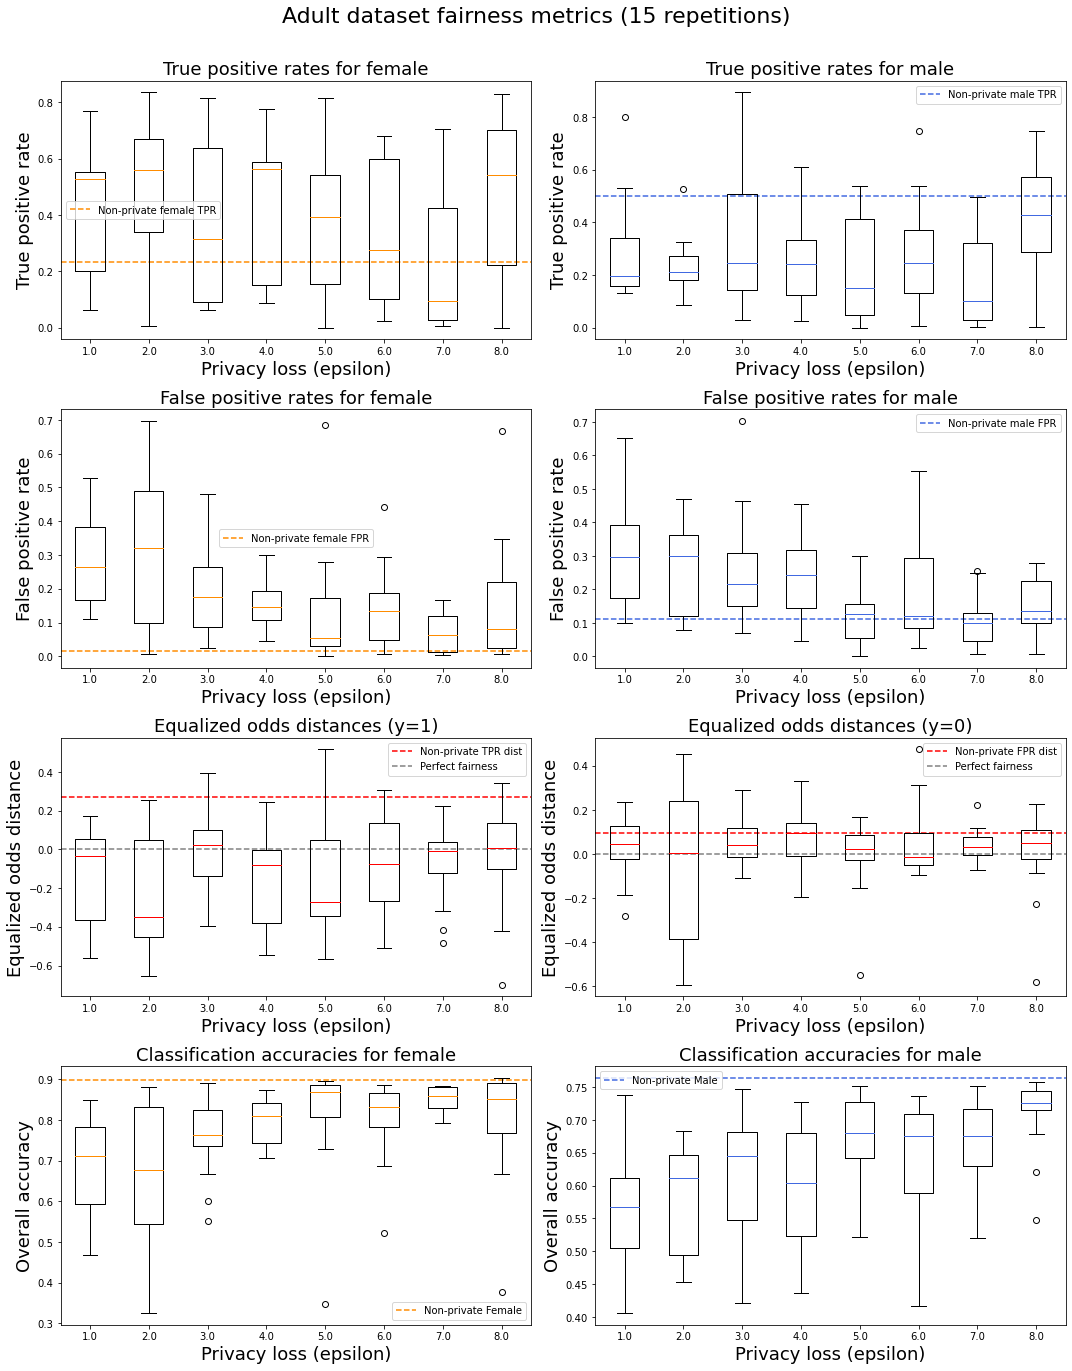

In [46]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_quail_dpctgan, plot_non_private=True)

## 4.6 PATE-CTGAN

In [48]:
# Try to load the dictionary with ten repetitions
adult_fairness_patectgan = np.load("adult_fairness_patectgan.npy", allow_pickle=True).item()

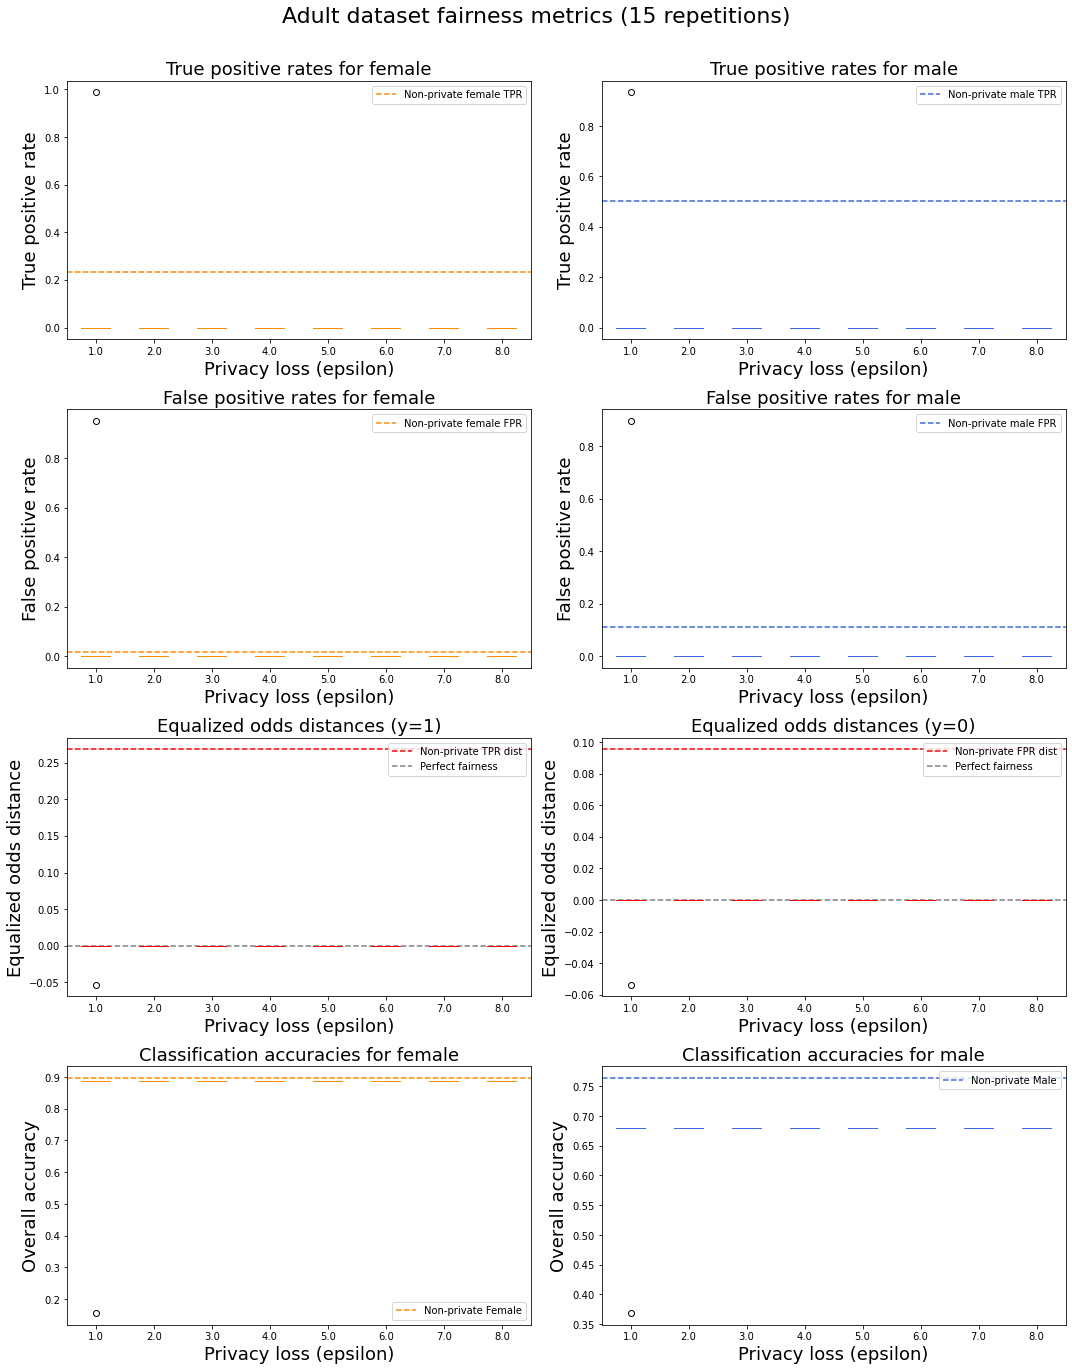

In [49]:
# Plot the fairness and accuracy metrics for female vs male
plot_fairness_dict(adult_fairness_patectgan, plot_non_private=True)

In [50]:
adult_fairness_patectgan

{1.0: [[(0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (228, 1702, 88, 3),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231)],
  [(0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (1232, 2516, 288, 87),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319),
   (0, 0, 2804, 1319)]],
 2.0: [[(0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),
   (0, 0, 1790, 231),


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa928c63-0856-4021-a156-02d09e35182a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>